# Предсказание вероятности клика по рекламному объявлению

**Краткое описание**

Требуется получить на выходе прогноз с высокой точностью вероятности клика по рекламному объявлению.
<br>На предикт ML модели выдается выборка объявлений доступных в текущий момент к показу, модель выдает по ним вероятность клика.

**Задача**

- Выбор модели для получения предсказаний.
- Обосновавние выбора

**План выполнения**
- Знакомство с данными
- Исследовательский анализ данных
- Предобработка данных
- Разработка дополнительных признаков (при необходимости)
- Построение baseline
- Обучение нескольких моделей
- Выбор лучшей модели
- Проверка лучшей модели на отложенной выборке
- Проверка важности признаков
- Заключение о проделанном исследовании

**Описание данных**
- `region_id` - id региона показа
- `city_id` - id города
- `tags_cont` - значение контекстного таргетинга
- `tags_bhv` - значение таргетинга по поведению
- `rubrica` - тематика объявления
- `rate` - ставка в рублях объявления
- `ctr_sort` - значение ctr объявления
- `rv_perc` - процент видимости объявления
- `slider` - тип рекламного блока
- `position_type` - значение позиции рекламного блока на странице сайта

**Метрики для оценки качества модели**
- основная метрика - `ROC AUC`
- дополнительная - `F1`

## Установка зависимостей

In [63]:
# !pip install pandas
# !pip install seaborn
# !pip install phik
# !pip install category_encoders
# !pip install python-dotenv
# !pip install mlflow
# !pip install psycopg2-binary
!pip freeze > requirements.txt

  Using cached psycopg2_binary-2.9.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.4 kB)
Using cached psycopg2_binary-2.9.9-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.0 MB)


In [18]:
# Импорт стандартных библиотек
import os

# Импорт библиотек для визуализации данных
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec

# Импорт библиотек для работы с данными
import pandas as pd

# Импорт дополнительных библиотек
from phik.report import plot_correlation_matrix

# Импорт пользовательских функций
from research_functions import (
    data_review,
    data_preprocessing,
    model_fitting,
    model_logging,
    models_comparison
    )

In [17]:
# Автоматическая перезагрузка модулей
%load_ext autoreload
%autoreload 2

# Импорт модуля research_functions
import research_functions

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Объявление глобальных переменных

In [3]:
DATA_DIR = 'data'
ASSETS_DIR = 'assets'
RANDOM_STATE = 42
TEST_SIZE = 0.1

pd.options.display.max_columns = 100
pd.options.display.max_rows = 64
pd.options.mode.copy_on_write = True

sns.set_theme(style='white', palette='husl')

%matplotlib inline
%config InlineBackend.figure_format = 'png'
%config InlineBackend.figure_format = 'retina'

## Знакомство с данными

In [4]:
data = pd.read_csv(os.path.join(DATA_DIR, 'dataset.csv'))
data_y23 = pd.read_csv(os.path.join(DATA_DIR, 'dataset_2023_10_30.csv'))

### dataset

In [5]:
data_review(data)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 803526 entries, 0 to 803525
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   region_id      803526 non-null  int64  
 1   city_id        803526 non-null  int64  
 2   tags_cont      803526 non-null  float64
 3   tags_bhv       803526 non-null  float64
 4   rubrica        803526 non-null  float64
 5   rate           803526 non-null  float64
 6   ctr_sort       803526 non-null  float64
 7   rv_perc        803526 non-null  float64
 8   slider         803526 non-null  int64  
 9   position_type  803526 non-null  int64  
 10  target         803526 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 67.4 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,590,0.0,0.500,1.812,1.7,1.3072,66.41,1,0,1
1,53,577,0.0,0.000,0.000,4.8,0.6568,46.79,1,0,1
2,48,0,0.0,0.000,1.950,1.7,1.3072,66.41,1,0,1
3,20,596,0.0,1.103,0.000,1.7,1.3072,94.44,0,0,1
4,290,0,0.0,0.750,0.000,1.0,1.1369,77.69,0,0,1



количество полных дубликатов строк: 255574

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 228
Количество уникальных записей в признаке 'city_id': 174
Количество уникальных записей в признаке 'tags_cont': 1527
Количество уникальных записей в признаке 'tags_bhv': 4687
Количество уникальных записей в признаке 'rubrica': 3153
Количество уникальных записей в признаке 'rate': 64
Количество уникальных записей в признаке 'ctr_sort': 3085
Количество уникальных записей в признаке 'rv_perc': 5238
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 26
Количество уникальных записей в признаке 'target': 2


### dataset_23

In [6]:
data_review(data_y23)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 648184 entries, 0 to 648183
Data columns (total 11 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   region_id      648184 non-null  int64  
 1   city_id        648184 non-null  int64  
 2   tags_cont      648184 non-null  float64
 3   tags_bhv       648184 non-null  float64
 4   rubrica        648184 non-null  float64
 5   rate           648184 non-null  float64
 6   ctr_sort       648184 non-null  float64
 7   rv_perc        648184 non-null  float64
 8   slider         648184 non-null  int64  
 9   position_type  648184 non-null  int64  
 10  target         648184 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 54.4 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,617,0.0,0.000,0.000,26.25,0.6608,89.97,0,0,1
1,284,0,0.0,0.000,1.750,1.50,1.8803,27.31,0,0,1
2,157,0,0.0,2.576,1.488,0.70,1.3899,78.42,1,0,1
3,228,0,0.0,0.000,0.000,0.75,1.6981,7.75,0,21,1
4,51,579,0.0,0.000,0.000,1.60,1.3530,77.69,0,0,1



количество полных дубликатов строк: 205732

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 226
Количество уникальных записей в признаке 'city_id': 183
Количество уникальных записей в признаке 'tags_cont': 7054
Количество уникальных записей в признаке 'tags_bhv': 8622
Количество уникальных записей в признаке 'rubrica': 2732
Количество уникальных записей в признаке 'rate': 76
Количество уникальных записей в признаке 'ctr_sort': 3364
Количество уникальных записей в признаке 'rv_perc': 5673
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 24
Количество уникальных записей в признаке 'target': 2


### Выводы
- оба набора данных представлены исключительно числовыми данными;
- в обоих наборах примерно 30% строк являются повторами;
- в наборах отсутствуют идентификаторы рекламных объявлений;
- ввиду схожести наборов и отсутствия идентификаторов принимаю решение их объединить

### common_df

In [7]:
df = pd.concat([data, data_y23], axis=0, ignore_index=True)

In [8]:
data_review(df)

Общая информация о наборе данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1451710 entries, 0 to 1451709
Data columns (total 11 columns):
 #   Column         Non-Null Count    Dtype  
---  ------         --------------    -----  
 0   region_id      1451710 non-null  int64  
 1   city_id        1451710 non-null  int64  
 2   tags_cont      1451710 non-null  float64
 3   tags_bhv       1451710 non-null  float64
 4   rubrica        1451710 non-null  float64
 5   rate           1451710 non-null  float64
 6   ctr_sort       1451710 non-null  float64
 7   rv_perc        1451710 non-null  float64
 8   slider         1451710 non-null  int64  
 9   position_type  1451710 non-null  int64  
 10  target         1451710 non-null  int64  
dtypes: float64(6), int64(5)
memory usage: 121.8 MB

Первые пять строк набора данных:


,region_id,city_id,tags_cont,tags_bhv,rubrica,rate,ctr_sort,rv_perc,slider,position_type,target
0,38,590,0.0,0.500,1.812,1.7,1.3072,66.41,1,0,1
1,53,577,0.0,0.000,0.000,4.8,0.6568,46.79,1,0,1
2,48,0,0.0,0.000,1.950,1.7,1.3072,66.41,1,0,1
3,20,596,0.0,1.103,0.000,1.7,1.3072,94.44,0,0,1
4,290,0,0.0,0.750,0.000,1.0,1.1369,77.69,0,0,1



количество полных дубликатов строк: 461322

количество пропущенных значений: 
    region_id        0
city_id          0
tags_cont        0
tags_bhv         0
rubrica          0
rate             0
ctr_sort         0
rv_perc          0
slider           0
position_type    0
target           0
dtype: int64

Вывод количества уникальных записей в каждом числовом признаке:
Количество уникальных записей в признаке 'region_id': 245
Количество уникальных записей в признаке 'city_id': 183
Количество уникальных записей в признаке 'tags_cont': 7301
Количество уникальных записей в признаке 'tags_bhv': 8813
Количество уникальных записей в признаке 'rubrica': 3843
Количество уникальных записей в признаке 'rate': 95
Количество уникальных записей в признаке 'ctr_sort': 5584
Количество уникальных записей в признаке 'rv_perc': 7679
Количество уникальных записей в признаке 'slider': 2
Количество уникальных записей в признаке 'position_type': 26
Количество уникальных записей в признаке 'target': 2


## Исследовательский анализ данных

In [9]:
df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
print('произведено удаление дубликатов строк')

произведено удаление дубликатов строк


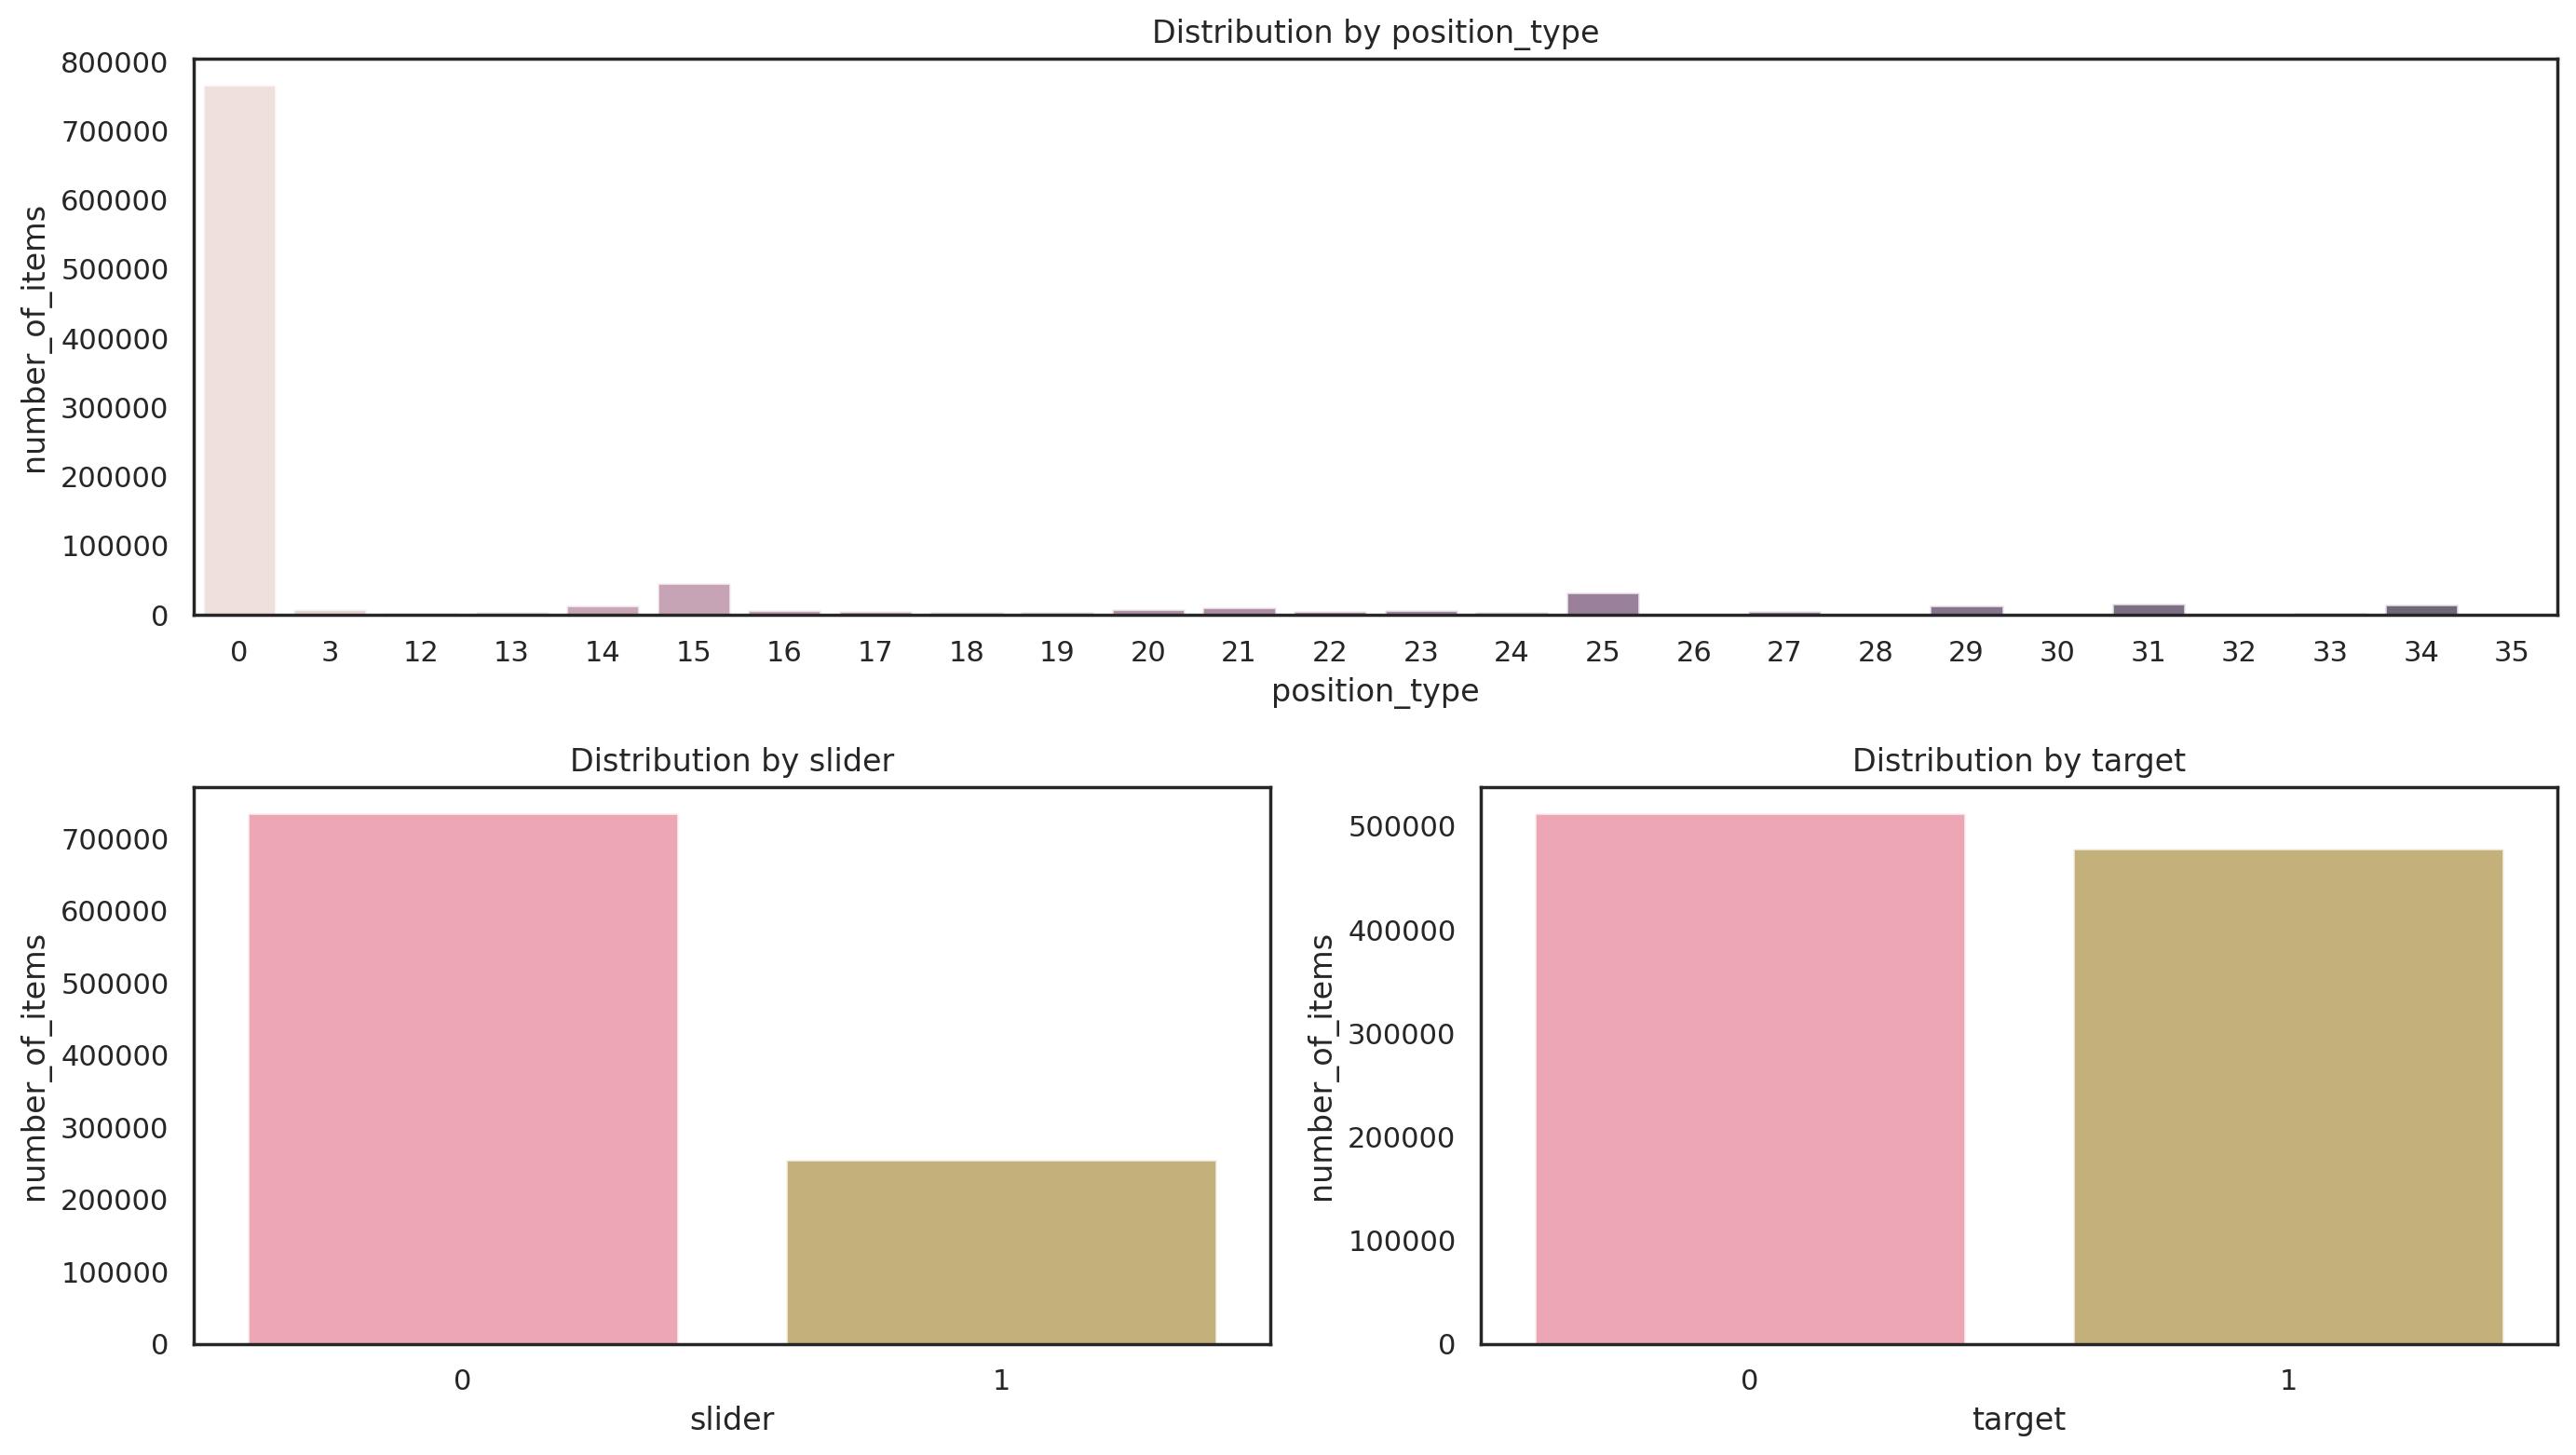

In [10]:
def plot_distribution(ax, data, title):
    sns.barplot(x=data.index,
                y=data.values,
                hue=data.index,
                ax=ax,
                alpha=0.7,
                legend=False)
    ax.set_ylabel('number_of_items')
    ax.set_title(title)

fig = plt.figure(figsize=(14, 8))
gs = GridSpec(2, 2, figure=fig)

titles = ['Distribution by position_type', 'Distribution by slider', 'Distribution by target']
data_columns = ['position_type', 'slider', 'target']

for i, (title, column) in enumerate(zip(titles, data_columns)):
    ax = fig.add_subplot(gs[i, :]) if i == 0 else fig.add_subplot(gs[1, i-1])
    plot_distribution(ax, df[column].value_counts(), title)

plt.savefig(os.path.join(ASSETS_DIR, 'Distribution by categories in the position_type, slider, target.png'))
plt.tight_layout()
plt.show()

### Анализ целевой переменной в зависимости от различных признаков

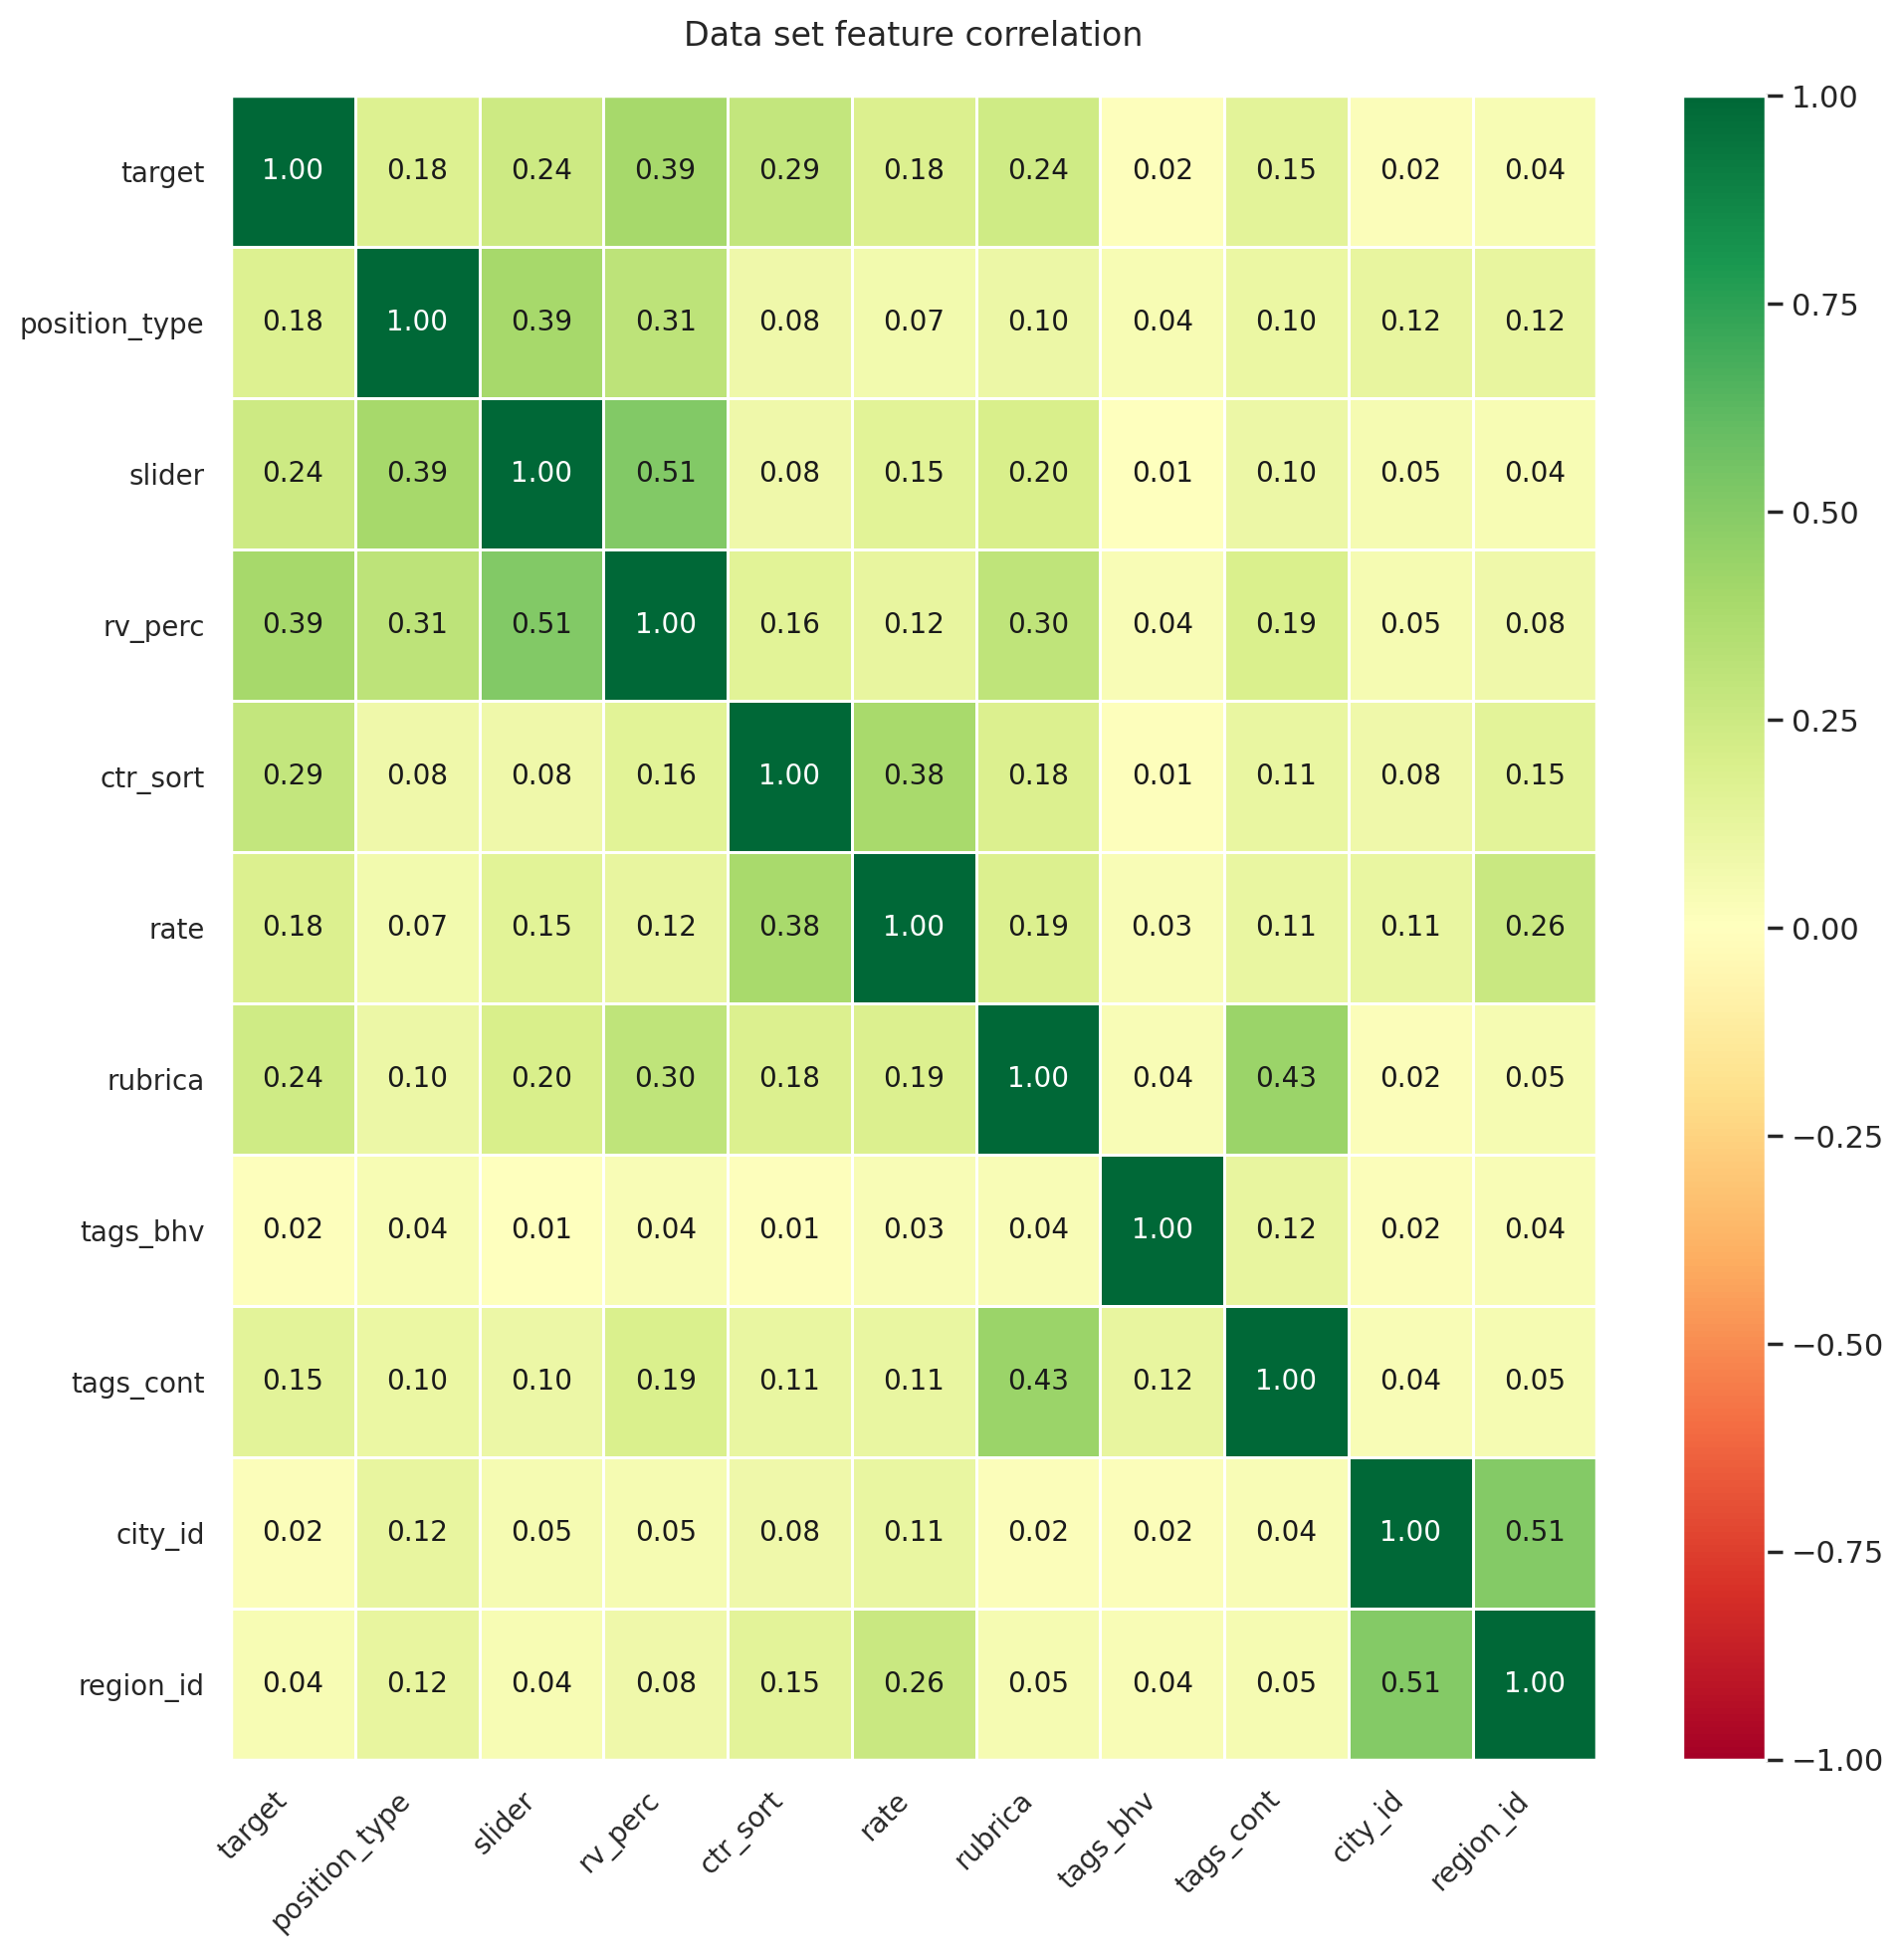

In [11]:
phik_overview = df.phik_matrix(interval_cols=df.columns.to_list())
sns.set()
plot_correlation_matrix(phik_overview.values,
						x_labels=phik_overview.columns,
						y_labels=phik_overview.index,
						fontsize_factor=1.0,
						figsize=(10, 10))
plt.xticks(rotation=45, ha='right')
plt.title(f'Data set feature correlation', fontsize=12, y=1.02)
plt.savefig(os.path.join(ASSETS_DIR, 'Dataset feature correlation.png'))
plt.tight_layout()

Сохранение датафрейма

In [10]:
# df.to_csv(os.path.join(DATA_DIR, 'clean_df.csv'))
df = pd.read_csv(os.path.join(DATA_DIR, 'clean_df.csv'), index_col='Unnamed: 0')

### Выводы
- в целевой переменной наблюдается незначительный дисбаланс классов;
- большой дисбаланс прослеживается в признаках `slider` и `position_type`;
- в признаке `position_type` почти все данные относятся к значению 0,
  <br>что делает данный признак малоинформативным кандидатом на исключение;
- изучение корреляций не выявило сильных скрытых зависимостей признаков с целевой переменной;
- между некоторыми признаками имеются небольшие логически объяснимые зависимости.

## Предобработка данных

In [12]:
X_train_bl, X_test_bl, y_train, y_test = data_preprocessing(test_size=TEST_SIZE,
                                                            dataset=df,
                                                            features=df.drop(['position_type', 'target'], axis=1).columns.tolist(),
                                                            target='target',
                                                            add_features=False)

размерности выборок: ((891349, 9), (99039, 9), (891349,), (99039,))


## Построение baseline

результаты кросс-вадидации: {'fit_time': 3.997, 'score_time': 0.655, 'test_roc_auc': 0.734, 'test_f1_micro': 0.669, 'test_f1': 0.652, 'test_f1_weighted': 0.669, 'test_f1_macro': 0.668}


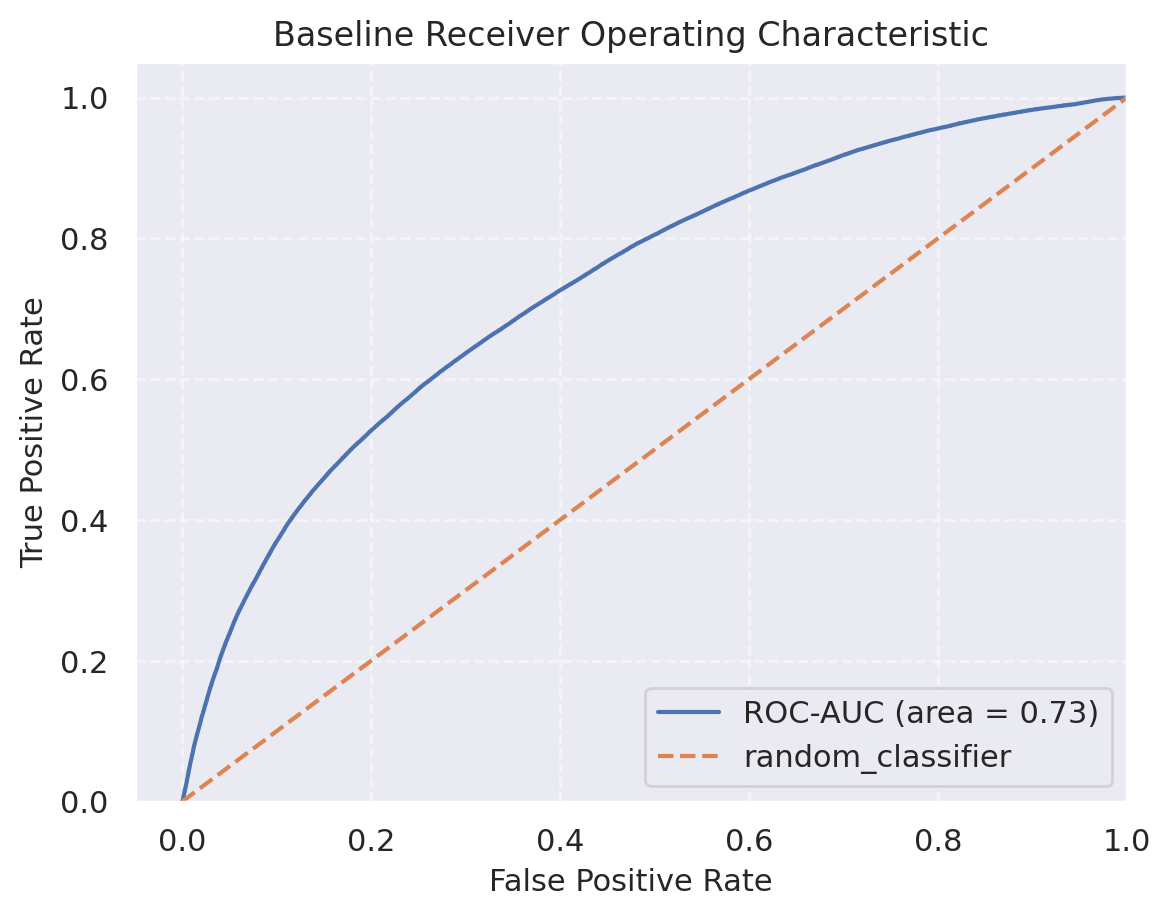

In [13]:
baseline_params = {'class_weight': 'balanced',
                   'C': 1.0,
                   'penalty': 'l2',
                   'max_iter': 1000,
                   'random_state': RANDOM_STATE}
f1_bl, roc_auc_bl, baseline = model_fitting(model_name='Baseline',
                                            features_train=X_train_bl,
                                            target_train=y_train,
                                            n_splits=round(X_train_bl.shape[0]/X_test_bl.shape[0]),
                                            params=baseline_params)

Логирование результатов

In [14]:
signature = mlflow.models.infer_signature(X_train_bl, y_train)
input_example = X_train_bl[:10]
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-06-14",
    "data_used": 'clean_common_df',
    "library_versions": {"mlflow": "2.11.3",
                         "scikit-learn":"1.5.0"}
}
metrics_bl = {'f1_score': f1_bl, 'roc_auc_score': roc_auc_bl}

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(


In [87]:
model_logging(signature=signature,
              input_example=input_example,
              metadata=metadata,
              metrics=metrics_bl,
              model=baseline,
              params=baseline_params,
              run_name='baseline_0_registry',
              reg_model_name='baseline_scope')

Successfully registered model 'baseline_scope'.
2024/06/14 11:03:27 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: baseline_scope, version 1
Created version '1' of model 'baseline_scope'.


Визуализация залогированных данных

Models and their metrics:


,experiment_name,run_name,model_name,model_version,f1_score,roc_auc_score
0,click_pred,baseline_0_registry,baseline_scope,1,0.652,0.734


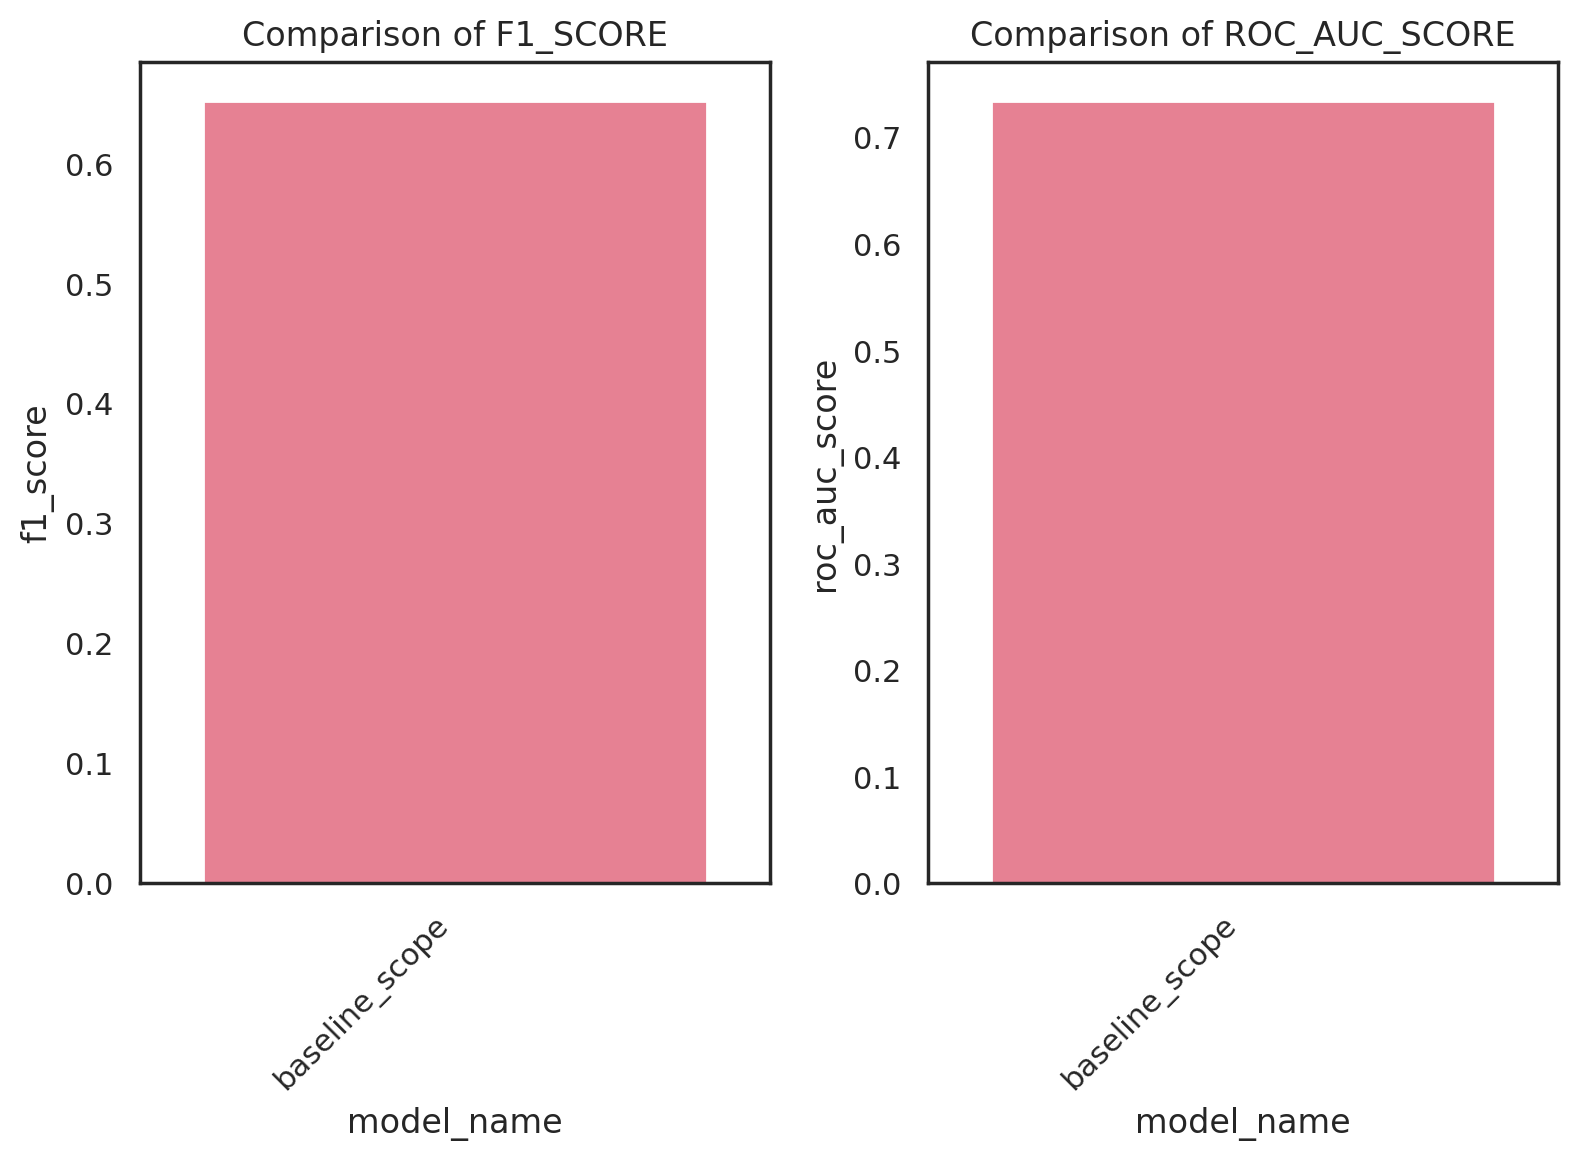

In [6]:
models_comparison(save_figure=False)

### Вывод
- в качестве baseline принята модель логистической регрессии с гиперпараметрами по умолчанию;
- получены базовые метрики: `ROC AUC = 0.734`, `F1 = 0.652`

## Обучение других моделей

### Случайный лес

результаты кросс-вадидации: {'fit_time': 110.026, 'score_time': 1.793, 'test_roc_auc': 0.748, 'test_f1_micro': 0.679, 'test_f1': 0.652, 'test_f1_weighted': 0.678, 'test_f1_macro': 0.677}


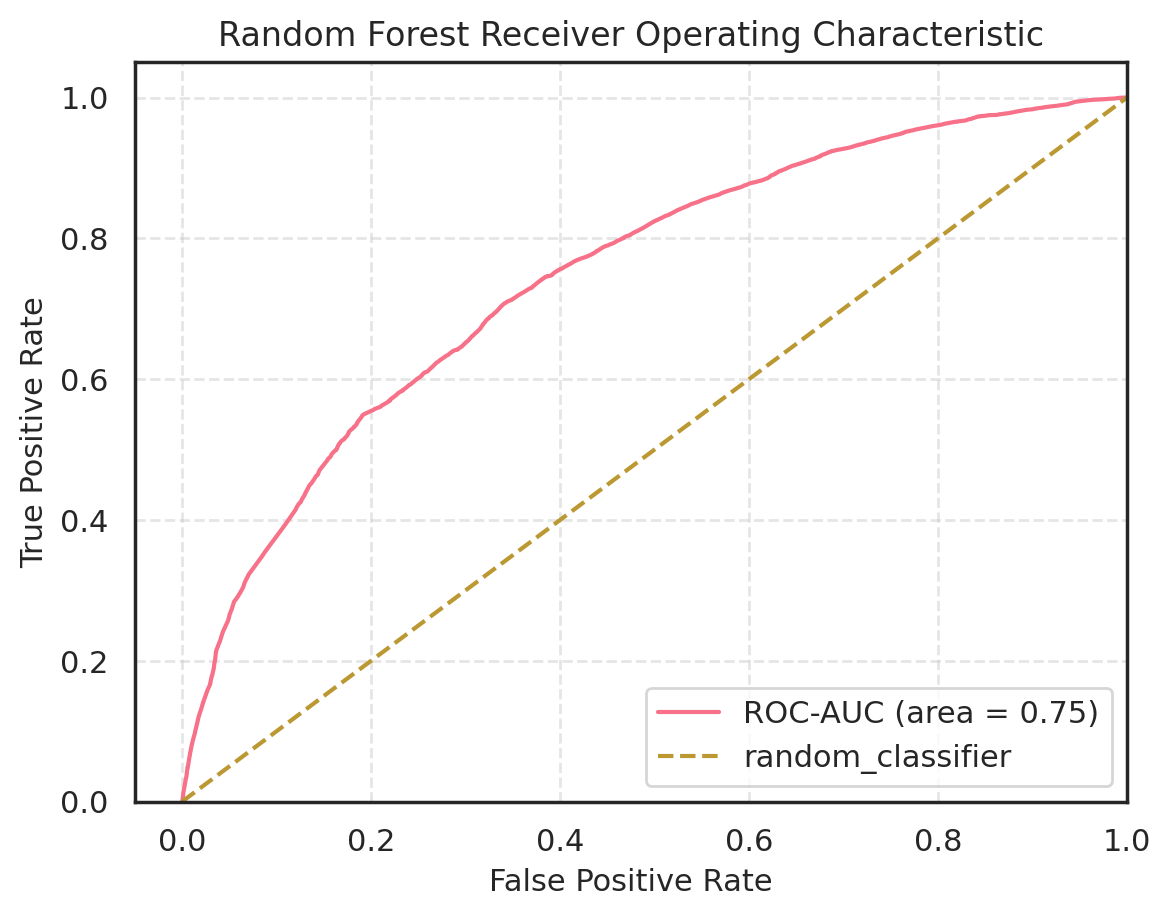

In [6]:
rf_params = {'n_estimators': 100,
             'criterion': 'gini',
             'max_depth': 3,
             'class_weight': 'balanced',
             'random_state': RANDOM_STATE,
             'n_jobs': -1}
f1_rf, roc_auc_rf, base_rf = model_fitting(model_name='Random Forest',
                                           features_train=X_train_bl,
                                           target_train=y_train,
                                           n_splits=round(X_train_bl.shape[0]/X_test_bl.shape[0]),
                                           params=rf_params)

In [7]:
signature = mlflow.models.infer_signature(X_train_bl, y_train)
input_example = X_train_bl[:10]
metadata = {
    "author": "denis_zeit",
    "training_date": "2024-06-14",
    "data_used": 'clean_common_df',
    "library_versions": {"mlflow": "2.11.3",
                         "scikit-learn":"1.5.0"}
}
metrics_rf = {'f1_score': f1_rf, 'roc_auc_score': roc_auc_rf}

model_logging(signature=signature,
              input_example=input_example,
              metadata=metadata,
              metrics=metrics_rf,
              model=base_rf,
              params=rf_params,
              run_name='base_rf_registry',
              reg_model_name='base_rf_scope')

/home/denis/Documents/main_venv/test_natiscope/scope.env/lib/python3.10/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
Successfully registered model 'base_rf_scope'.
2024/06/14 12:20:37 INFO mlflow.store.model_registry.abstract_store: Waiting up to 60 seconds for model version to finish creation. Model name: base_rf_sco

Models and their metrics:


,experiment_name,run_name,model_name,model_version,f1_score,roc_auc_score
0,click_pred,baseline_0_registry,baseline_scope,1,0.652,0.734
1,click_pred,base_rf_registry,base_rf_scope,1,0.652,0.748


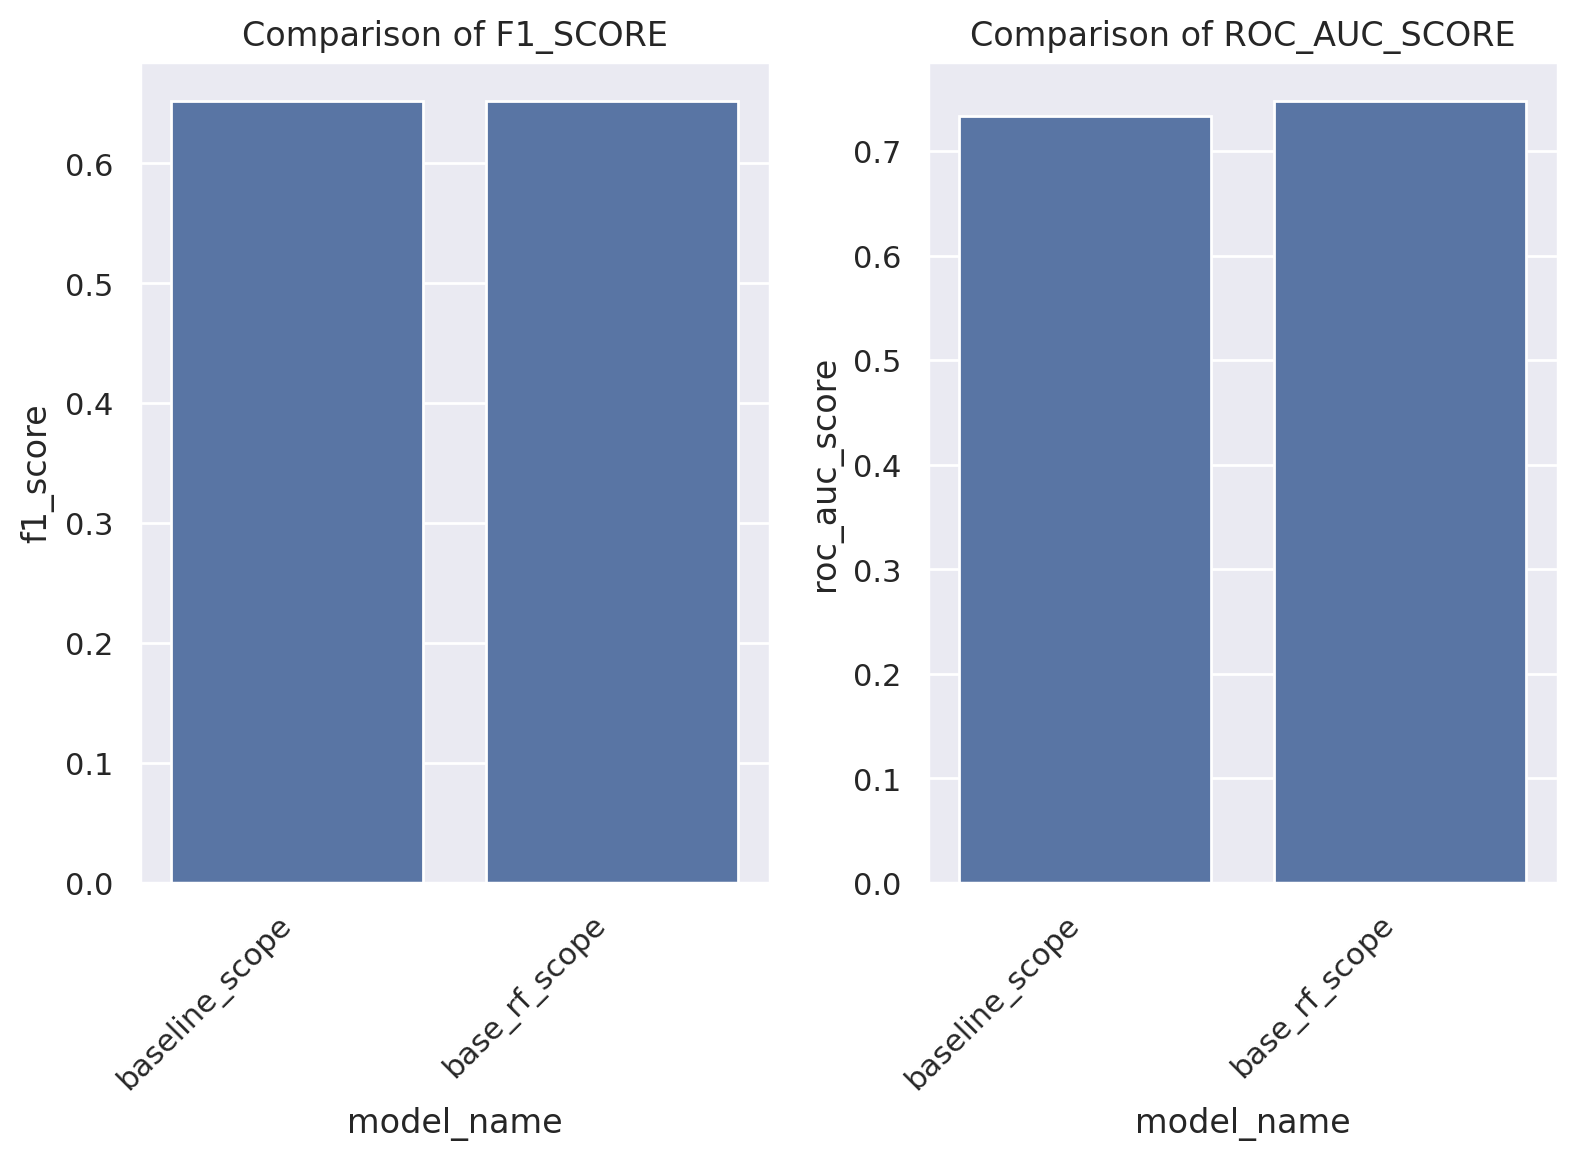

In [15]:
models_comparison(save_figure=False)

#### Вывод
- модель случайного леса с гиперпараметрами по умолчанию
  <br>показала результат незначительно превосходящий базовую модель.